In [71]:
import numpy as np
import torch
from tensordict import TensorDict
from torch import Tensor
from torch.nn import Module


class ThetaConstructor(Module):
    """Construct theta from the encoded theta.
    This is necessary for two reasons:
    1.  Theta generated by the meta-solver is a single tensor, but solver takes a dictionary of parameters.
        Thus, we need to split the tensor into multiple solver parameters (e.g. initial guess + preconditioner).
    2.  Theta generated by the meta-solver may be encoded in a lower-dimensional space,
        and we need to decode it to the original space.
        This is important becasue the variance of CVFG is lower in the lower-dimensional space.

    """

    def __init__(self, params) -> None:
        super().__init__()
        self.params = params

    def forward(self, theta: Tensor) -> TensorDict:
        theta_dict = TensorDict({})
        idx = 0
        for k, v in self.params.items():
            assert v.codec.param_dim == np.prod(v.shape)
            param = v.codec.decode(theta[:, idx : idx + v.codec.latent_dim])
            theta_dict[k] = param.reshape(-1, *v.shape)
            idx += v.codec.latent_dim
        # theta_dict["enc"] = theta.unsqueeze(-1)
        return theta_dict


class Codec(Module):
    def __init__(self, param_dim: int, latent_dim: int) -> None:
        """Initialize the codec.

        Args:
            param_dim (int): solver parameter dimension
            latent_dim (int): latent dimension
        """
        super().__init__()
        assert param_dim >= latent_dim
        self.param_dim = param_dim
        self.latent_dim = latent_dim

    def forward(self, x: Tensor) -> Tensor:
        raise NotImplementedError

    def encode(self, x: Tensor) -> Tensor:
        raise NotImplementedError

    def decode(self, z: Tensor) -> Tensor:
        raise NotImplementedError


class IdentityCodec(Codec):
    def __init__(self, param_dim: int = 128, latent_dim: int = 128):
        assert param_dim == latent_dim
        super().__init__(param_dim, latent_dim)

    def encode(self, x: Tensor) -> Tensor:
        z = x
        return z

    def decode(self, z: Tensor) -> Tensor:
        x = z
        return x


class SinCodec(Codec):
    def __init__(self, param_dim: int = 128, latent_dim: int = 128):
        super().__init__(param_dim, latent_dim)
        frequencies = torch.arange(1, latent_dim + 1).unsqueeze(-1) # (latent_dim, 1)
        phases = (torch.tensor([i / (param_dim + 1) for i in range(1, param_dim + 1)]) * torch.pi).unsqueeze(0) # (1, param_dim)
        self.basis = torch.sin(frequencies * phases)  # (latent_dim, param_dim)
        self.basis = self.basis.unsqueeze(0)  # (1, latent_dim, param_dim) to broadcast for batch

    def encode(self, x: Tensor) -> Tensor:
        x = x.reshape(-1, self.param_dim, 1)
        z = torch.matmul(self.basis, x)
        return z

    def decode(self, z: Tensor) -> Tensor:
        z = z.reshape(-1, self.latent_dim, 1)
        x = torch.matmul(self.basis.transpose(1, 2), z)  # (bs, out_dim, 1)
        return x


In [73]:
x_recon = codec.decode(z)

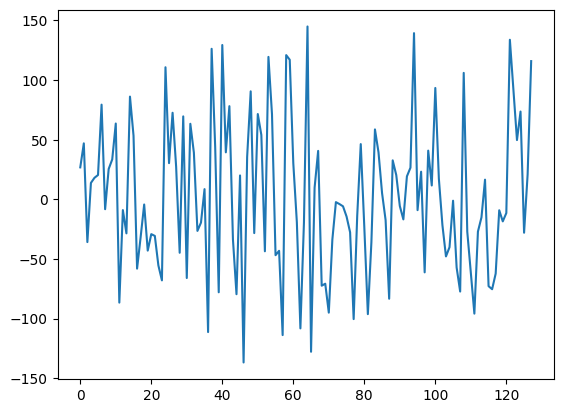

In [74]:
plt.plot(x_recon[0, :])

In [13]:
latent_dim = 64
phase = torch.tensor([i / (latent_dim + 1) for i in range(1, latent_dim + 1)])

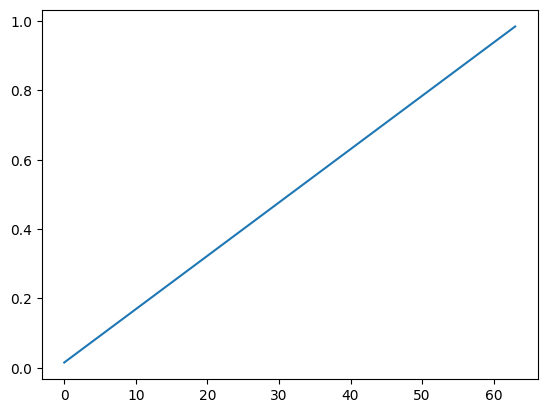

In [14]:
plt.plot(phase)

In [15]:
param_dim = 128
latent_dim = 64
frequencies = torch.arange(1, param_dim + 1).unsqueeze(-1) # (param_dim, 1)
phases = torch.tensor([i / (latent_dim + 1) for i in range(1, latent_dim + 1)]) * torch.pi # (latent_dim,)
basis = torch.sin(frequencies * phases)  # (param_dim, latent_dim)
basis = basis.unsqueeze(0)  # (1, latent_dim, param_dim) to broadcast for batch

torch.Size([1, 128, 64])


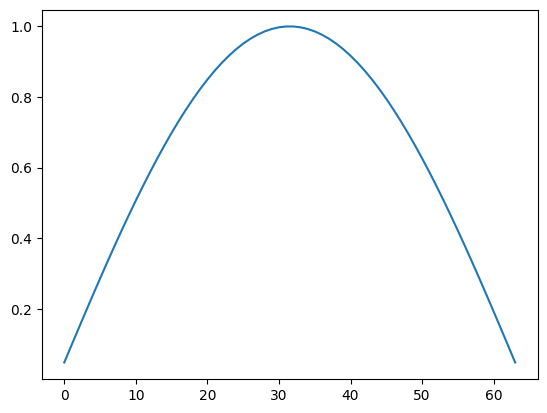

In [23]:
print(basis.shape)
plt.plot(basis[0, 0])

In [ ]:
torch.linspace()